In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 12:09:02.205574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 12:09:03.058032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/kor_rnb_bigram.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

249543


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿_.,]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

249535
['<start> 떠나는_길에 니가 내게 말했지 <end>', '<start> 너는 바라는_게 너무나 많아 <end>', '<start> 잠깐이라도 널 안 바라보면 <end>', '<start> 머리에 불이 나버린다니까 <end>', '<start> 나는 흐르려는 눈물을 참고 <end>', '<start> 하려던 얘길 어렵게 누르고 <end>', '<start> 그래 미안해 라는 한 마디로 <end>', '<start> 너랑 나눈 날들 마무리했었지 <end>', '<start> 달디달고 달디달고 달디단_밤양갱 밤양갱 <end>', '<start> 내가 먹고 싶었던 건 달디단_밤양갱 밤양갱이야 <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fb64b317cd0> 
 [[    2 16456   111 ...     0     0     0]
 [    2    85  4485 ...     0     0     0]
 [    2 22115    13 ...     0     0     0]
 ...
 [    2    44 15452 ...     0     0     0]
 [    2    32  2985 ...     0     0     0]
 [    2   326  3314 ...     0     0     0]]


In [7]:
tensor.shape

(249535, 21)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : 난
7 : me
8 : 내
9 : love
10 : it
11 : baby
12 : to
13 : 널
14 : 날
15 : oh
16 : t
17 : and
18 : don
19 : 내가
20 : my


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (249535, 21)
소스문장 길이:  20
타겟문장 길이:  20


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (199628, 20)
Target Train 길이:  (199628, 20)
Source Test 길이:  (49907, 20)
Target Test 길이:  (49907, 20)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 12:09:28.274919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 12:09:28.318805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 12:09:28.319018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 20), dtype=tf.int32, name=None), TensorSpec(shape=(256, 20), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 20), dtype=tf.int32, name=None), TensorSpec(shape=(256, 20), dtype=tf.int32, name=None))>


L355
2024-04-12 12:09:28.320155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 12:09:28.320245: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 12:09:29.576756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 20, 30001), dtype=float32, numpy=
array([[[-0.00350045, -0.00048478,  0.00363152, ..., -0.00073361,
          0.00773789, -0.00346668],
        [-0.00692718,  0.00020809,  0.0023543 , ...,  0.00874663,
          0.00317815, -0.01096965],
        [-0.00431041, -0.0032669 ,  0.00090945, ..., -0.0020174 ,
          0.00688588, -0.00388776],
        ...,
        [-0.01432049,  0.06876943,  0.03754336, ..., -0.03077883,
          0.01389416, -0.06120778],
        [-0.02016394,  0.08257564,  0.01004721, ...,  0.03479781,
          0.00421   , -0.01902001],
        [-0.03779195,  0.06445729,  0.04512701, ..., -0.04402138,
         -0.02265909, -0.06297269]],

       [[-0.00350045, -0.00048478,  0.00363152, ..., -0.00073361,
          0.00773789, -0.00346668],
        [ 0.00189643,  0.00087721,  0.01075137, ...,  0.00440233,
         -0.00386208,  0.0036324 ],
        [ 0.00759046, -0.00138647, -0.00700205, ..., -0.00387468,
          0.01525173, -0.00870769],
        .

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712923785.055673  515940 service.cc:145] XLA service 0x3584d350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712923785.055724  515940 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 12:09:45.106154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 12:09:45.634772: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712923786.179161  516006 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712923786.608814  516005 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 1740 bytes spill stores, 2152 bytes spill loads

I0000 00:00:1712923789.

779/779 ━━━━━━━━━━━━━━━━━━━━ 213s 261ms/step - loss: 1.9593
Epoch 2/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 1.4333
Epoch 3/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 263ms/step - loss: 1.3096
Epoch 4/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 1.1931
Epoch 5/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 1.0802
Epoch 6/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 263ms/step - loss: 0.9905
Epoch 7/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 0.9265
Epoch 8/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 0.8812
Epoch 9/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 0.8458
Epoch 10/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 205s 262ms/step - loss: 0.8227


In [19]:
model.save('rnn_kor_rnb_bigram.keras')
model.save('rnn_kor_rnb_bigram.h5')
tf.saved_model.save(model, 'rnn_kor_rnb_bigram.tf')

INFO:tensorflow:Assets written to: rnn_kor_rnb_bigram.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_rnb_bigram.tf/assets


In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m on my way to wonderland <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 <unk> 반대 <unk> <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 <unk> 반대 <unk> <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 dear my star <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 돌아오는 거래 <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 올까요 또 오게 될까요 <end> '

rnb_이별의 출구 - 온시온  
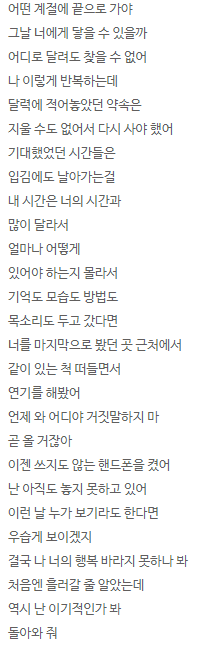

In [27]:
exit = ['어떤', '그날', '어디로', '나', '달력에', '지울', '기대', '입김', '내', '많이']
for word in exit:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 어떤 <unk> <end> 
<start> 그날 후 <unk> <unk> <end> 
<start> 어디로 튈지 몰라 매일 난 <unk> <end> 
<start> 나 <unk> 반대 <unk> <end> 
<start> <unk> <unk> <end> 
<start> 지울 수도 없으니 <end> 


<start> 기대 가득한 풍경 <end> 
<start> 입김 그리고 <unk> <end> 
<start> 내 <unk> 아프지_않을 너 어_어 <end> 
<start> 많이 힘들던 날들에 <end> 


all genre_임수-goood  
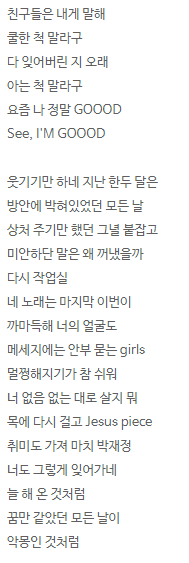

In [28]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 내게 <end> 
<start> 쿨한 이별이 될_줄 알았어 <end> 
<start> 다 <unk> <end> 
<start> 아는 게 아니라고 <end> 
<start> 요즘 날 웃게_만드는 너_때문에 <end> 
<start> see you later <end> 


<start> <unk> <unk> <end> 
<start> 방안에 숨어 있는 <end> 
<start> 상처 뿐인 슬픈 어제 <end> 
<start> 미안하단 한마디를 전하고 <end> 


: 